#### In the next notebook, we will 
1. Perform data cleaning operations on selected datasets
2. Visualize the overall time series data
3. Use seasonal decomposition methods to extract the trend and seasonality from the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")
plt.style.use(style='seaborn')

#### Import air quality data into current workspace, for selected pollutant and state

In [18]:
selected_pollutant='SO2'
selected_state='Michigan'

In [19]:
years=os.listdir(f'DataAQ/{selected_pollutant}-{selected_state}')
years=[int(y.split('-')[-1]) for y in years]
years.sort()
print(years)

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [20]:
d=pd.DataFrame({})
for year in years:
    if len(d)==0:
        d=pd.read_csv(f'DataAQ/{selected_pollutant}-{selected_state}/{selected_pollutant}-{selected_state}-{year}')
    else:
        d=pd.concat([d,pd.read_csv(f'DataAQ/{selected_pollutant}-{selected_state}/{selected_pollutant}-{selected_state}-{year}')],axis=0)
print(d.shape)

(272235, 20)


In [21]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272235 entries, 0 to 3130
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Date                                272235 non-null  object 
 1   Source                              272235 non-null  object 
 2   Site ID                             272235 non-null  int64  
 3   POC                                 272235 non-null  int64  
 4   Daily Max 1-hour SO2 Concentration  272235 non-null  float64
 5   UNITS                               272235 non-null  object 
 6   DAILY_AQI_VALUE                     272235 non-null  int64  
 7   Site Name                           129774 non-null  object 
 8   DAILY_OBS_COUNT                     272235 non-null  int64  
 9   PERCENT_COMPLETE                    272235 non-null  float64
 10  AQS_PARAMETER_CODE                  272235 non-null  int64  
 11  AQS_PARAMETER_DESC          

In [22]:
d["Date"]=pd.to_datetime(d["Date"])
d.Date.info()

<class 'pandas.core.series.Series'>
Int64Index: 272235 entries, 0 to 3130
Series name: Date
Non-Null Count   Dtype         
--------------   -----         
272235 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.2 MB


In [23]:
d.head()

,Date,Source,Site ID,POC,Daily Max 1-hour SO2 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,1980-01-01,AQS,260030902,1,0.0,ppb,0,NaN,24,100.0,42401,Sulfur dioxide,NaN,NaN,26,Michigan,3,Alger,46.408279755,-86.640714337
1,1980-01-02,AQS,260030902,1,0.0,ppb,0,NaN,24,100.0,42401,Sulfur dioxide,NaN,NaN,26,Michigan,3,Alger,46.408279755,-86.640714337
2,1980-01-03,AQS,260030902,1,0.0,ppb,0,NaN,24,100.0,42401,Sulfur dioxide,NaN,NaN,26,Michigan,3,Alger,46.408279755,-86.640714337
3,1980-01-04,AQS,260030902,1,0.0,ppb,0,NaN,24,100.0,42401,Sulfur dioxide,NaN,NaN,26,Michigan,3,Alger,46.408279755,-86.640714337
4,1980-01-05,AQS,260030902,1,0.0,ppb,0,NaN,24,100.0,42401,Sulfur dioxide,NaN,NaN,26,Michigan,3,Alger,46.408279755,-86.640714337


#### Identify site with most number of data points, which will be used later for time series analysis

In [24]:
print(d["Site Name"].value_counts().head())
site_name=d["Site Name"].value_counts().index[0]
site_count=d["Site Name"].value_counts()[0]

print(f'\nSite with most number of data points is {site_name} with {site_count} data points')

Southwestern H.S.                               14803
GR-MONROE                                       14573
Port Huron                                      12692
Allen Park                                      10774
WARREN - FIRE STATION 29900 HOOVER AT COMMON     9507
Name: Site Name, dtype: int64

Site with most number of data points is Southwestern H.S. with 14803 data points


In [25]:
d=d[d['Site Name']==site_name]

#### Remove columns having unique values for all entries

In [26]:
print(f"Before: d.shape={d.shape}")
d=d.loc[:,d.nunique()>1]
d=d.reset_index(drop=True)
print(f"After: d.shape={d.shape}")

d.head()

Before: d.shape=(14803, 20)
After: d.shape=(14803, 7)


,Date,Daily Max 1-hour SO2 Concentration,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,SITE_LATITUDE,SITE_LONGITUDE
0,1980-01-01,46.1,64,23,96.0,42.3027864681917,-83.1065304278455
1,1980-01-04,72.8,96,23,96.0,42.3027864681917,-83.1065304278455
2,1980-01-05,38.1,54,23,96.0,42.3027864681917,-83.1065304278455
3,1980-01-08,17.9,24,23,96.0,42.3027864681917,-83.1065304278455
4,1980-01-10,77.8,101,23,96.0,42.3027864681917,-83.1065304278455


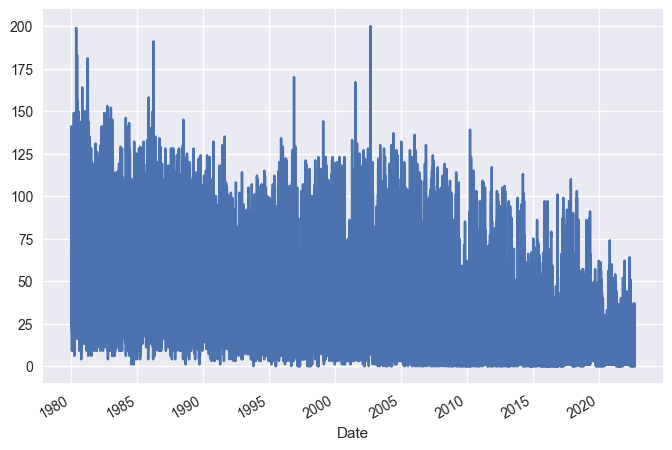

In [27]:
d=d.groupby([d['Date']]).mean()
d["DAILY_AQI_VALUE"].plot()
plt.show()


#### Select AQI metric for further analyses

In [28]:
d=d[['DAILY_AQI_VALUE']]
d.head()

,DAILY_AQI_VALUE
Date,
1980-01-01,64.0
1980-01-04,96.0
1980-01-05,54.0
1980-01-08,24.0
1980-01-10,101.0


#### Interpolate missing/NaN values in the time series using spline interpolation

In [29]:
idx = pd.date_range(min(d.index),max(d.index))
d=d.reindex(idx,fill_value=np.nan)
d['DAILY_AQI_VALUE']= d['DAILY_AQI_VALUE'].interpolate(option='spline')

In [30]:
d.shape

(15614, 1)

### <span style="color:red">For convenience, the previous data imputation operations are packaged in a single python file, with unit tests implemented to check for correctness.</span>

### UnitTest/InterpolationAQI.py contains a function called TS_imputation() which combines the prevous feature engineering operations

In [31]:
from UnitTest import InterpolationAQI

d_packaged=InterpolationAQI.TS_imputation(selected_pollutant,selected_state)
d_packaged.shape

(15614, 1)

### UnitTest/InterpolationAQI.py contains a class called TestAQIimputation() which implements the unit test.

In [17]:
current=os.getcwd()

os.chdir(os.path.expanduser('UnitTest'))

!python -m unittest InterpolationAQI.py

os.chdir(os.path.expanduser(current))


.
----------------------------------------------------------------------
Ran 1 test in 87.111s

OK


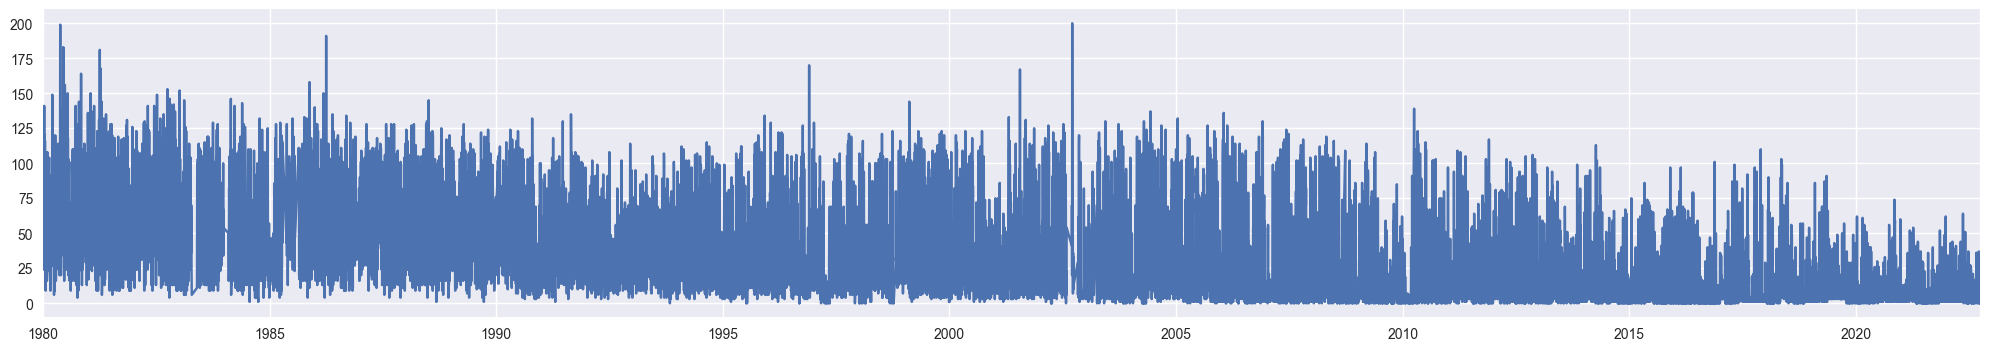

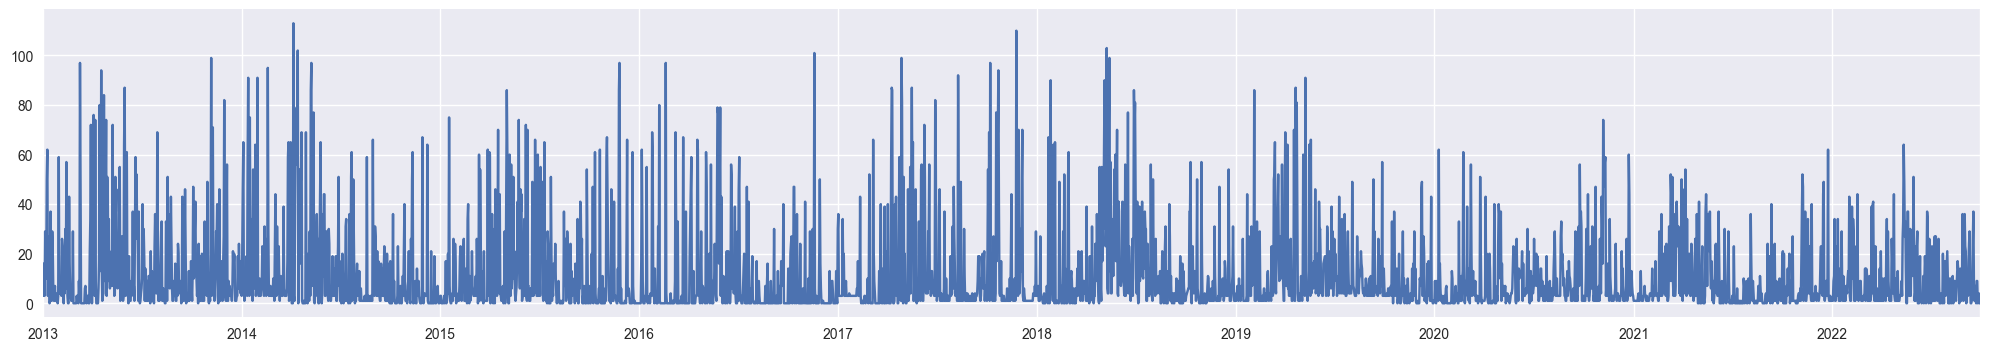

In [32]:
d.rename(columns = {'DAILY_AQI_VALUE':'AQI'}, inplace = True)
   
plt.figure(figsize=(25,4))
d['AQI'].plot()
plt.show()

plt.figure(figsize=(25,4))
d.last('10Y')['AQI'].plot()
plt.show()

In [33]:
d=d.last('10Y')

#### Dickey-Fuller test for stationarity

In [34]:
from statsmodels.tsa.stattools import adfuller

result=adfuller(d.AQI.dropna())
print(f'ADF statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF statistic: -7.660138383562996
p-value: 1.6972558040683725e-11


Null hypothesis: series is not stationary
1. If p-value > 0.05, series is stationary
2. If p-value < 0.05, series is not stationary

In [35]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

Decomposition of daily sampled AQI data

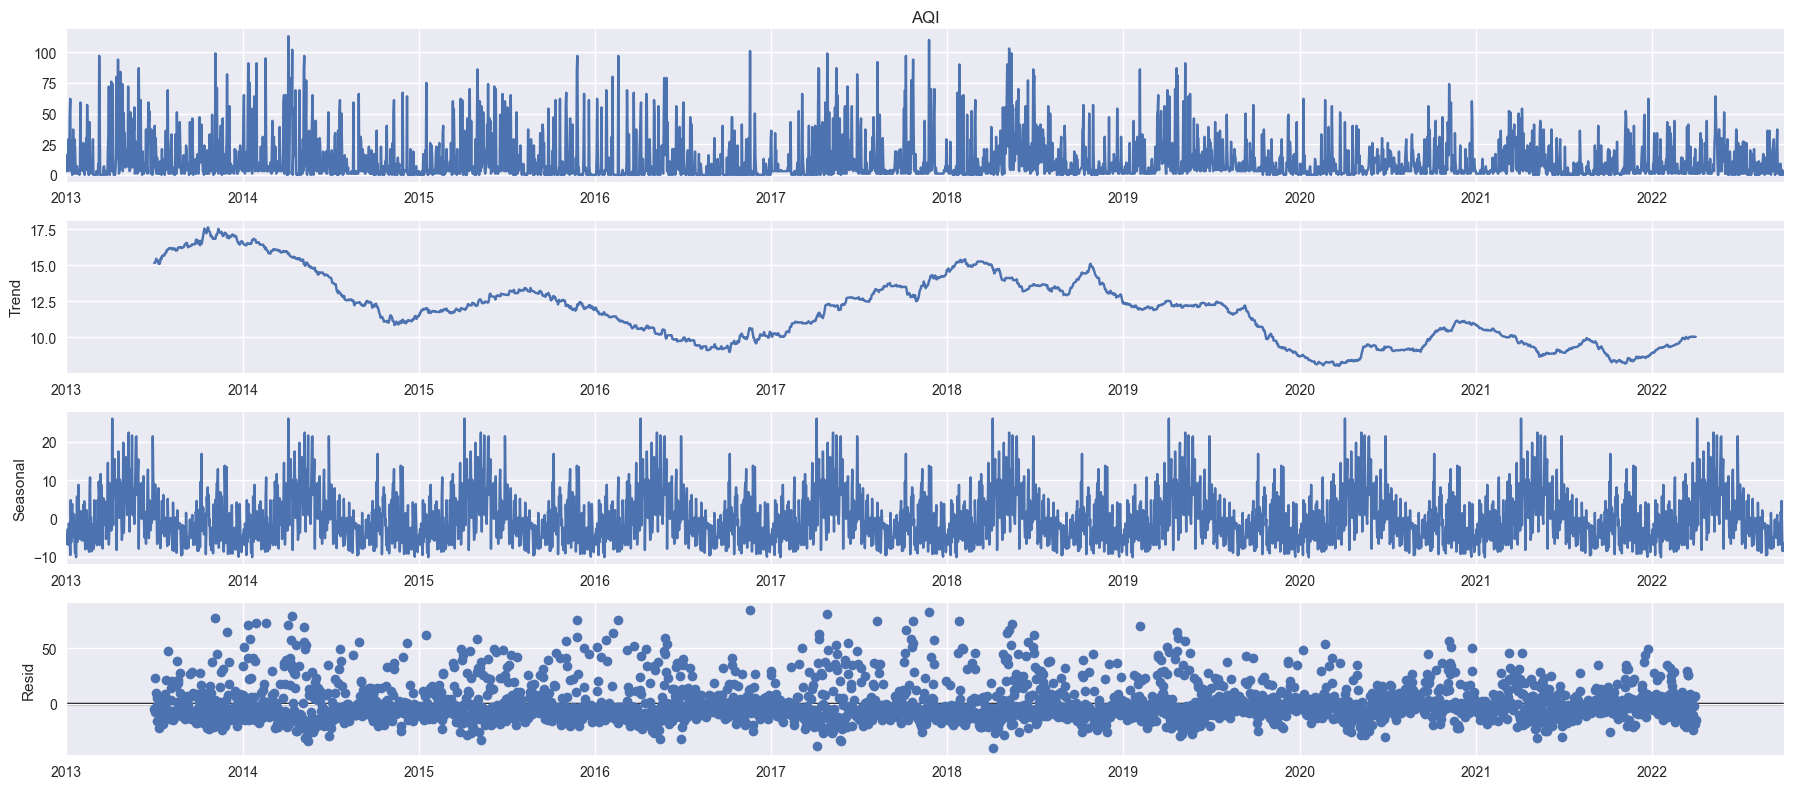

In [36]:
decomposition = sm.tsa.seasonal_decompose(d['AQI'], period=365, model='additive')
fig = decomposition.plot()
plt.show()

Decomposition of weekly sampled AQI data

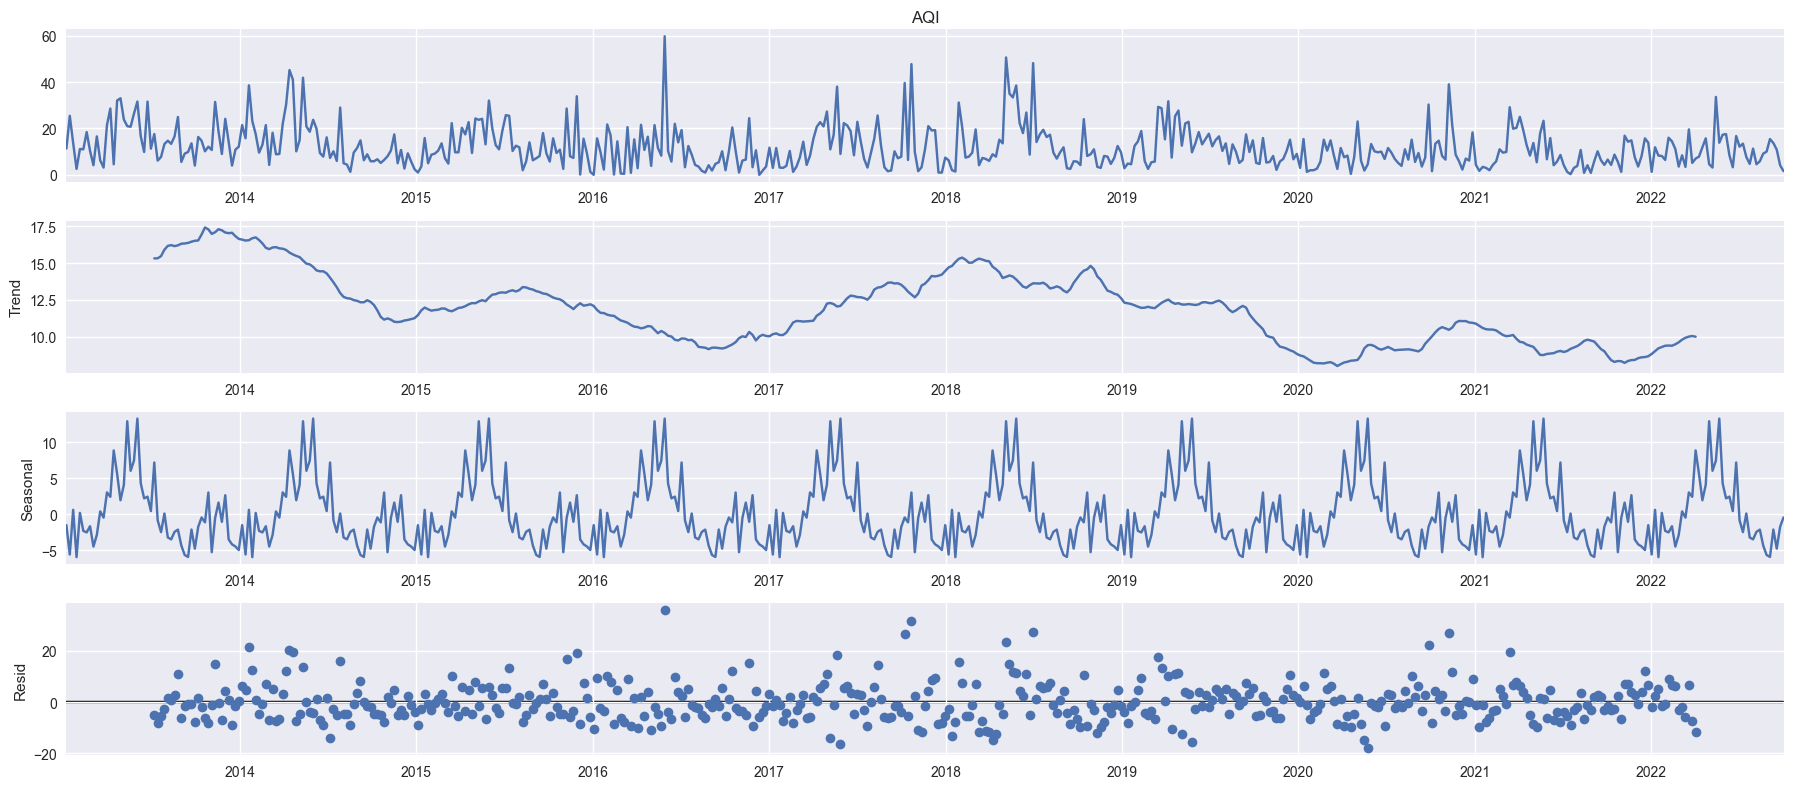

In [37]:
decomposition = sm.tsa.seasonal_decompose(d['AQI'].resample('W').mean(), period=52, model='additive')
fig = decomposition.plot()
plt.show()

Decomposition of monthly sampled AQI data

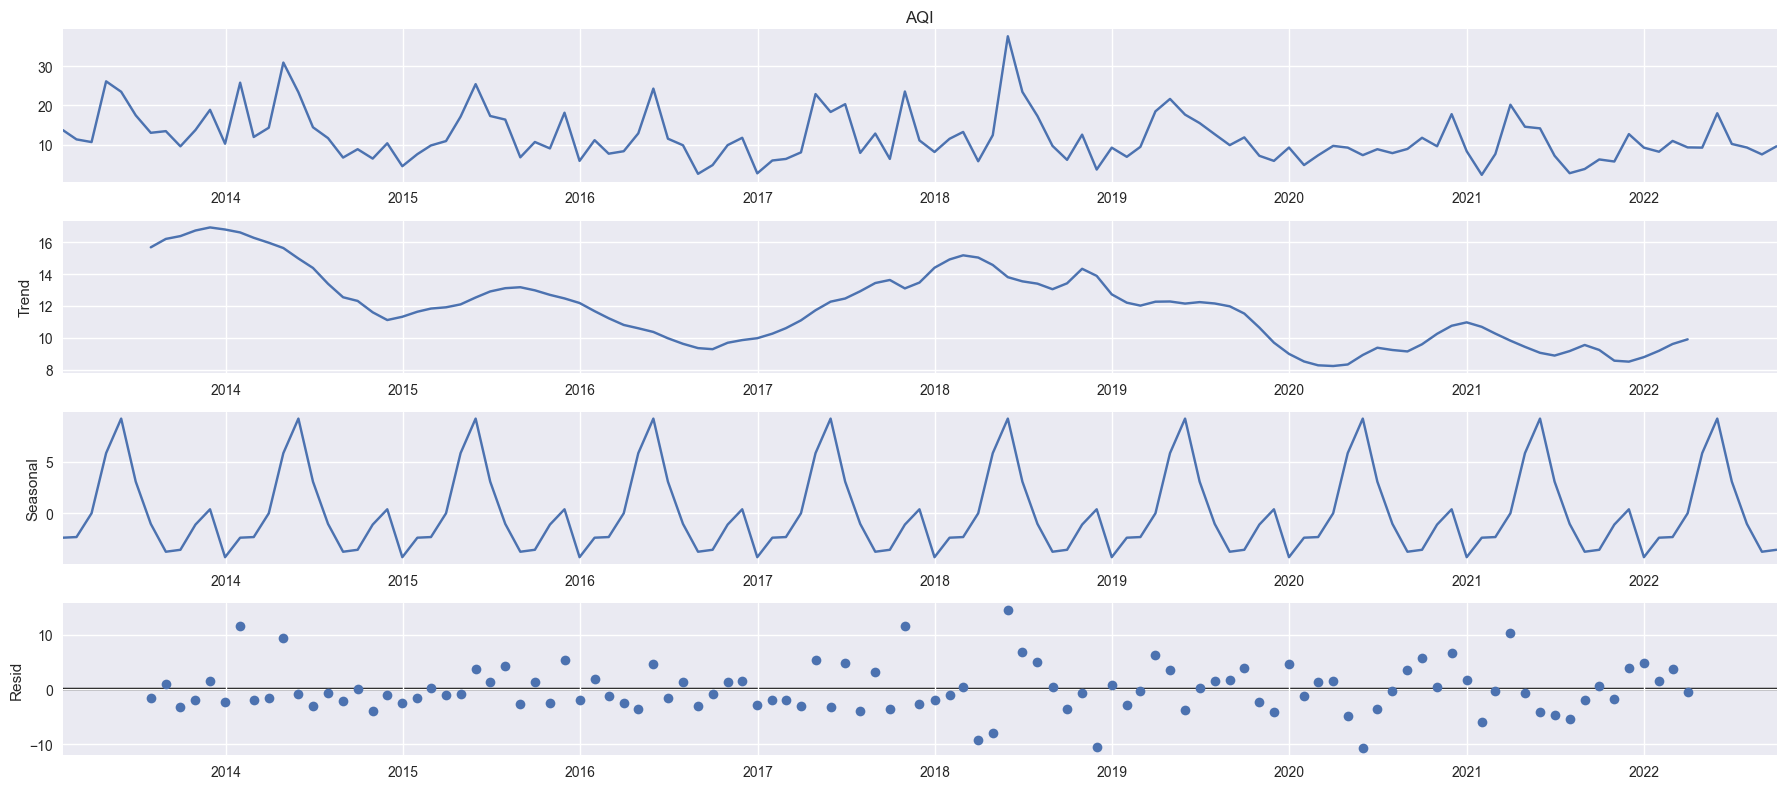

In [38]:
decomposition = sm.tsa.seasonal_decompose(d['AQI'].resample('M').mean(), period=12, model='additive')
fig = decomposition.plot()
plt.show()

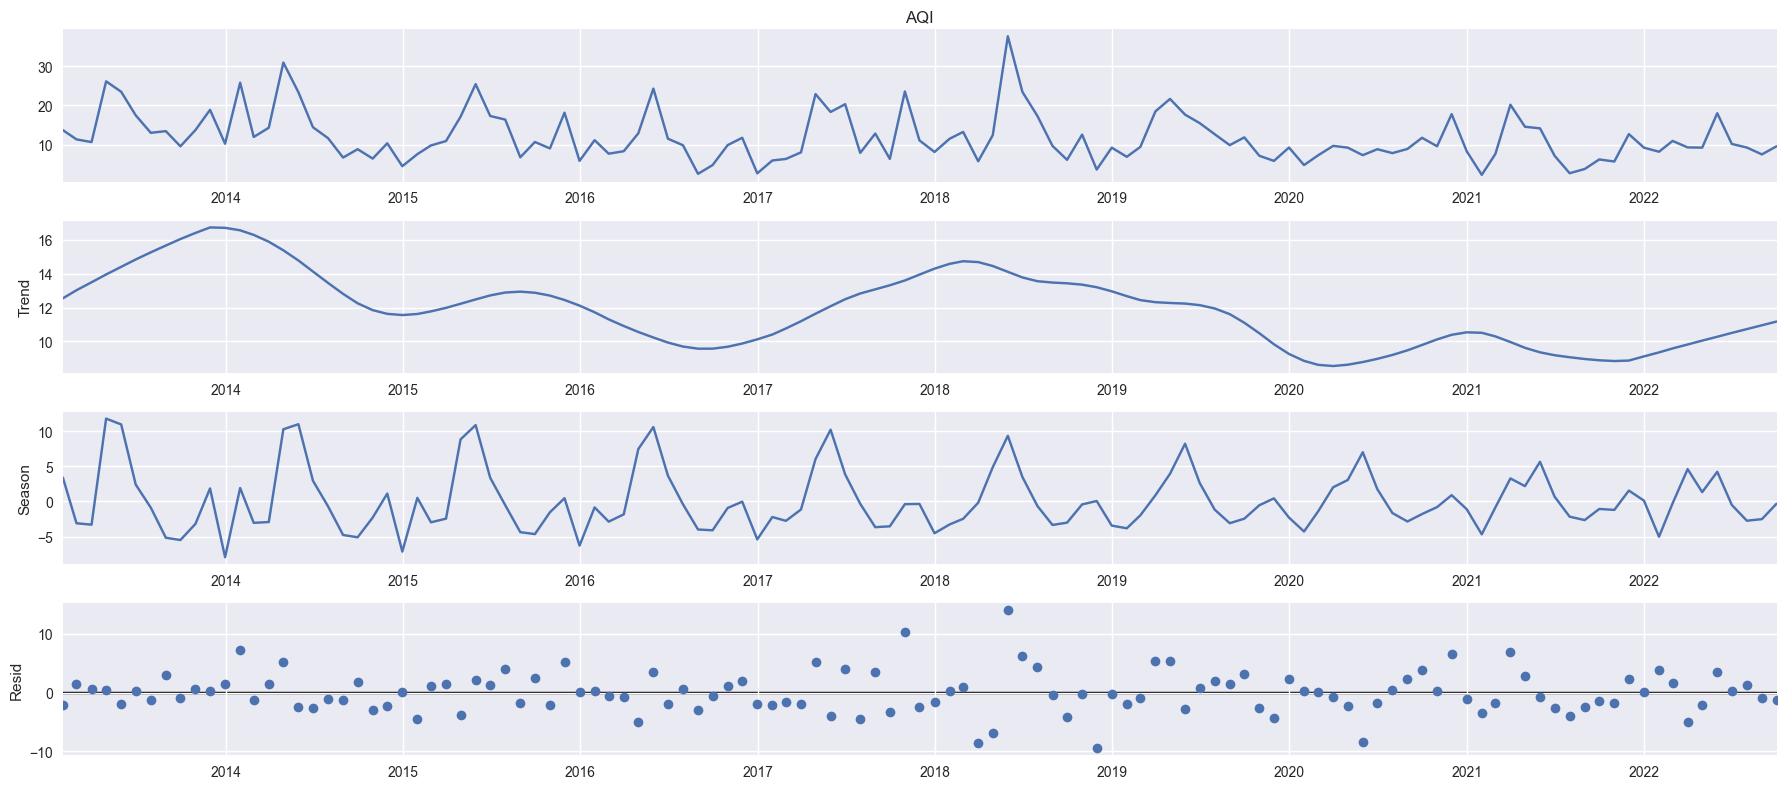

In [39]:
from statsmodels.tsa.seasonal import STL
stl = STL(d['AQI'].resample("M").mean(), seasonal=13,period=12)
res = stl.fit()
fig = res.plot()

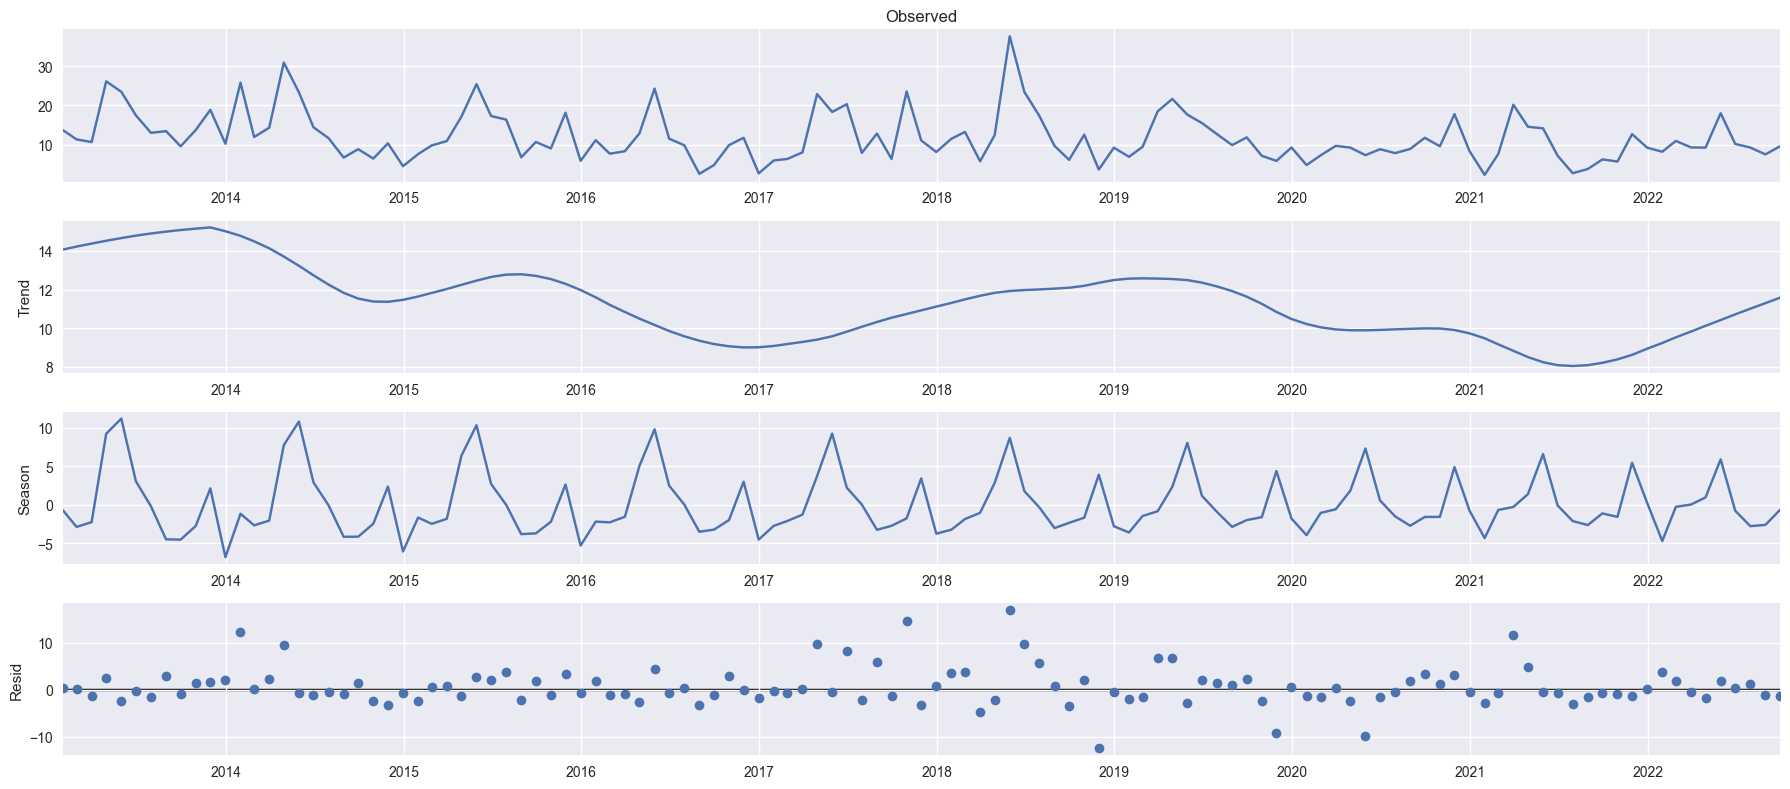

In [40]:
from statsmodels.tsa.seasonal import STL
stl = STL(d.resample("M").mean(), seasonal=13,period=12,robust=True)
res = stl.fit()
fig = res.plot()

In [41]:
d.resample('M').mean().to_csv(f'DataAQ/{selected_pollutant}-{selected_state}.csv')

#### In the next notebook, we will 
1. Use grid search to identify p,q parameters
2. Construct a SARIMA model
3. Make predictions for the AQI